In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from config import DATA_FOLDER, METHYLATION_CSV_FILE, NUMBER_OF_CPG_SITES
from utils import get_patterns

In [2]:
%matplotlib inline

In [3]:
patterns = get_patterns(NUMBER_OF_CPG_SITES)
patterns

['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']

# Get data

In [4]:
# This is a big file
# Reading the file can be faster if it is saved as a pickle/parquet file
df = pd.read_csv(f'{DATA_FOLDER}/{METHYLATION_CSV_FILE}')

# Look at the data

In [5]:
df.head()

,strand,CpG_Coordinates,`000,`001,`010,`011,`100,`101,`110,`111,Sample_ID,Replicate,Tissue
0,r,10035:10044:10046,1077,9,0,0,0,0,0,4,1,Rep2,cfDNA
1,r,10035:10044:10053,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA
2,r,10035:10044:10058,1069,17,0,0,0,0,0,4,1,Rep2,cfDNA
3,r,10035:10044:10071,1072,14,0,0,0,0,0,4,1,Rep2,cfDNA
4,r,10035:10044:10075,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15392183 entries, 0 to 15392182
Data columns (total 13 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   strand           object
 1   CpG_Coordinates  object
 2   `000             int64 
 3   `001             int64 
 4   `010             int64 
 5   `011             int64 
 6   `100             int64 
 7   `101             int64 
 8   `110             int64 
 9   `111             int64 
 10  Sample_ID        int64 
 11  Replicate        object
 12  Tissue           object
dtypes: int64(9), object(4)
memory usage: 1.5+ GB


In [7]:
# There are 2 technical replicates and 2 tissue types
for x in ['strand', 'Replicate', 'Tissue']:
    print(df[x].unique())

['r' 'f']
['Rep2' 'Rep1']
['cfDNA' 'Islet']


In [8]:
# We don't have 2 technical replicates for Islet tissue type
# We have more samples of circulating free DNA
df.groupby(['strand', 'Tissue', 'Replicate'])['Sample_ID'].nunique()

strand  Tissue  Replicate
f       Islet   Rep1         32
        cfDNA   Rep1         47
                Rep2         48
r       Islet   Rep1         32
        cfDNA   Rep1         47
                Rep2         48
Name: Sample_ID, dtype: int64

In [9]:
# There are 80 samples
print(df['Sample_ID'].min())
print(df['Sample_ID'].max())
print(df['Sample_ID'].nunique())

1
80
80


# Coverage analysis

In [10]:
# Calculate the median and coefficient of variation (CV) for single CpG coverage in each tissue

# Coverage analysis can help us evaluate data quality

# The CpG_Coordinates are not split below, so this is not truly "single CpG coverage"
# I have treated the phased triple as a single epigenetic locus

# A common approach is to sum across all methylation patterns
# to get total coverage at that phased triple locus

df['Total_Coverage'] = df[patterns].sum(axis=1)
df_locus = df.groupby(['Tissue', 'CpG_Coordinates'])['Total_Coverage'].sum().reset_index()
df_strand = df.groupby(['Tissue', 'strand', 'CpG_Coordinates'])['Total_Coverage'].sum().reset_index()
df_rep = df.groupby(['Tissue', 'Replicate', 'CpG_Coordinates'])['Total_Coverage'].sum().reset_index()

In [11]:
# The mean values are higher than median
# The distribution is skewed (clearly visible in boxplots below)

stats = df_locus.groupby(['Tissue'])['Total_Coverage'].agg(['median', 'mean', 'std']).reset_index()
stats['CV'] = stats['std'] / stats['mean']
stats

,Tissue,median,mean,std,CV
0,Islet,4762.0,8534.123892,9733.194154,1.140503
1,cfDNA,90208.5,178228.548366,222046.851894,1.245855


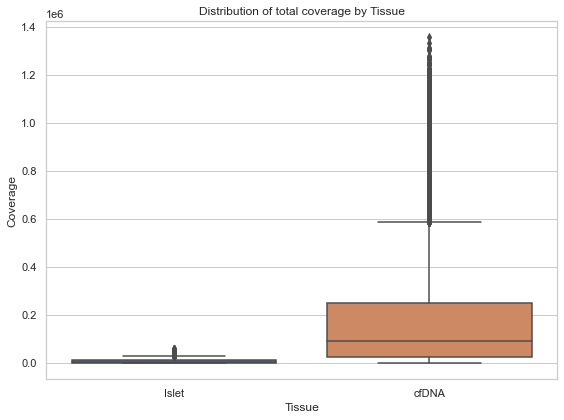

In [12]:
# There seem to be a lot of outliers
sns.set(style='whitegrid')
plt.figure(figsize=(8,6))
sns.boxplot(x='Tissue', y='Total_Coverage', data=df_locus)
plt.title("Distribution of total coverage by Tissue")
plt.ylabel("Coverage")
plt.xlabel("Tissue")
plt.tight_layout()

plt.show()

## Coverage stats by Tissue and Strand

In [13]:
# The median values in forward strand are higher compared to reverse strand in both tissue types
df_strand_stats = df_strand.groupby(['Tissue','strand'])['Total_Coverage'].agg(['mean','median','std']).reset_index()
df_strand_stats['CV'] = df_strand_stats['std'] / df_strand_stats['mean']
df_strand_stats 

,Tissue,strand,mean,median,std,CV
0,Islet,f,4911.560906,2920.5,5521.360744,1.124156
1,Islet,r,3861.656847,1799.0,4674.749670,1.210555
2,cfDNA,f,101495.106485,54521.0,122704.943440,1.208974
3,cfDNA,r,81457.929502,30721.5,110953.440426,1.362095


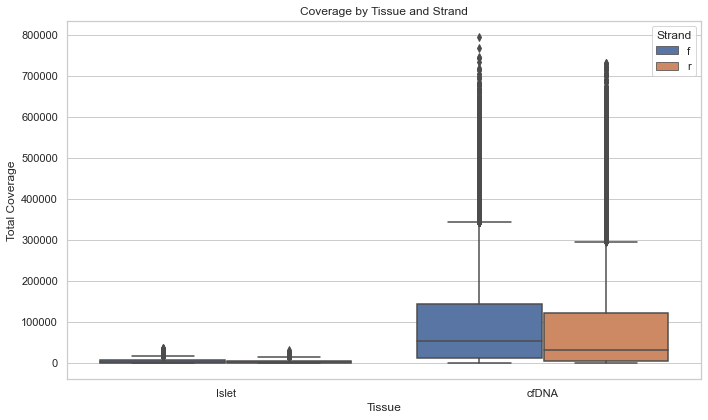

In [14]:
plt.figure(figsize=(10,6))

sns.boxplot(x='Tissue', y='Total_Coverage',hue='strand',data=df_strand)
plt.title("Coverage by Tissue and Strand")
plt.xlabel("Tissue")
plt.ylabel("Total Coverage")
plt.legend(title="Strand")
plt.tight_layout()

plt.show()

## Coverage stats by Tissue and Replicate

In [15]:
# In cfDNA, replicate 2 has higher median compared to replicate 1
# But the variation in cfDNA coverage within each repl icate is similar
# It might be worth validating the wet lab protocols used in both replicates

df_rep_stats = df_rep.groupby(['Tissue','Replicate'])['Total_Coverage'].agg(['mean','median','std']).reset_index()
df_rep_stats['CV'] = df_rep_stats['std'] / df_rep_stats['mean']
df_rep_stats

,Tissue,Replicate,mean,median,std,CV
0,Islet,Rep1,8534.123892,4762.0,9733.194154,1.140503
1,cfDNA,Rep1,79456.485655,40297.5,98926.656313,1.245042
2,cfDNA,Rep2,98808.192434,49968.5,123128.895556,1.246141


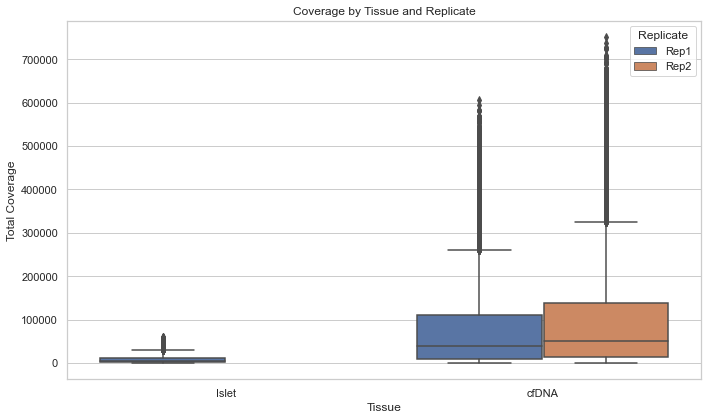

In [16]:
plt.figure(figsize=(10,6))

sns.boxplot(x='Tissue', y='Total_Coverage', hue='Replicate', data=df_rep)
plt.title("Coverage by Tissue and Replicate")
plt.xlabel("Tissue")
plt.ylabel("Total Coverage")
plt.legend(title="Replicate")
plt.tight_layout()

plt.show()

## Biomarker identification

In [17]:
# Identify PMPs with high specificity for tissue differentiation, minimizing false
# positives for Tissue #1 while allowing some false negatives

In [18]:
# Calculate the mean variant read fraction (VRF) for each PMP in both tissues

## Questions

In [19]:
# How does sequencing depth affect specificity confidence?

In [20]:
# For the top 10 PMPs, estimate the threshold of reads required to confidently call Tissue #2 
# at a sequencing depth of 1 million reads.

In [21]:
# Validate the hypothesis by comparing the specificity of the top 10 PMPs against individual CpG sites.